In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from sklearn.model_selection import KFold, LeaveOneOut

from bamf.bamf import *

import time

np.random.seed(12345)

# Define number of K-Folds 

In [2]:
# Comment out if using Leave One Out
K = 3

# Define variable names

In [3]:
# number of species
NS = 7

species = ["s"+str(i+1) for i in range(NS)]
species

['s1', 's2', 's3', 's4', 's5', 's6', 's7']

# Import sequenced data

In [4]:
full_data = pd.read_csv("gLV_data/Simulated_gLV_data_full.csv")
full_data

,Treatments,Time,s1,s2,s3,s4,s5,s6,s7
0,exp_1,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,exp_1,48.0,0.298559,0.159095,0.081960,0.215479,0.016468,0.168590,0.000057
2,exp_2,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000
3,exp_2,48.0,0.286262,0.165522,0.065139,0.155305,0.025074,0.212555,0.000000
4,exp_3,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000,0.100000
...,...,...,...,...,...,...,...,...,...
249,exp_125,48.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.337060,0.118508
250,mono_exp_126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
251,mono_exp_126,48.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.548540,0.000000
252,mono_exp_127,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000


## sum-of-OD data

In [5]:
sum_data = pd.read_csv("gLV_data/Simulated_gLV_data_sum.csv")
sum_data

,Treatments,Time,OD,s1,s2,s3,s4,s5,s6,s7
0,exp_1,0.0,0.700000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,exp_1,1.0,0.603124,0.139175,0.115084,0.112920,0.111055,0.104585,0.116198,0.086675
2,exp_1,2.0,0.863875,0.180531,0.128074,0.122424,0.121131,0.104713,0.130274,0.073863
3,exp_1,3.0,1.025633,0.218637,0.138798,0.128066,0.130070,0.101389,0.141819,0.062099
4,exp_1,4.0,0.868276,0.249608,0.147425,0.130253,0.137868,0.096018,0.150858,0.051734
...,...,...,...,...,...,...,...,...,...,...
6218,mono_exp_127,44.0,0.149115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144137
6219,mono_exp_127,45.0,0.157048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144124
6220,mono_exp_127,46.0,0.126141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144121
6221,mono_exp_127,47.0,0.133857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144130


# Define function to make predictions on test data

In [6]:
# Define function to make predictions on test data

def test_model(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # test full community
        output, stdv, COV = model.predict(x_test, tspan)

        # save predictions after initial value 
        for i, (true, pred, std) in enumerate(zip(output_true[1:], output[1:], stdv[1:])):
            y_true += list(true)
            y_pred += list(pred)
            y_std  += list(std)
            test_times += [tspan[i+1]]*numspecies
            all_species_names += list(species)
            test_treatments += [treatment]*numspecies

        if plot:
            # increase teval
            t_eval = np.linspace(0, tspan[-1]+5)
            steps = len(t_eval)
            output, stdv, COV = model.predict(x_test, t_eval)   

            # plot the results
            plt.figure(figsize=(9, 6))
            ylim = 0
            for i in range(numspecies):
                out = output[:,i]
                out_true = output_true[:, i]
                std = stdv[:, i]
                if ylim < np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1]):
                    ylim = np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1])
                if out[0] > 0:
                    plt.scatter(tspan, out_true, color='C{}'.format(i))
                    plt.plot(t_eval, out, label=f"Predicted {species[i]}", color='C{}'.format(i))
                    plt.fill_between(t_eval, out-std, out+std, color='C{}'.format(i), alpha=0.2)

            plt.xlabel("time", fontsize=16)
            plt.ylabel("Abundance", fontsize=16)
            plt.legend(loc='upper left')
            plt.ylim([0, np.min([ylim, 3])])
            plt.title(f"Treatment {treatment} predictions")
            #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
            #plt.close()
            plt.show()

    return test_treatments, test_times, all_species_names, y_true, y_pred, y_std

# Define function to make predictions on test data

def test_mf(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1]+5)
        steps = len(t_eval)
        output, stdv, COV = model.predict(x_test, t_eval)   
        
        # apply lossy function
        output_true = np.sum(output_true, 1)
        output = np.sum(output, 1)
        stdv = np.sum(stdv, 1)

        # plot the results
        plt.figure(figsize=(9, 6))
        plt.scatter(tspan, output_true, color='C0')
        plt.plot(t_eval, output, label=f"Predicted sum", color='C0')
        plt.fill_between(t_eval, output-stdv, output+stdv, color='C0', alpha=0.2)

        plt.xlabel("time", fontsize=16)
        plt.ylabel("Abundance", fontsize=16)
        plt.legend(loc='upper left')
        plt.title(f"Treatment {treatment} predictions")
        #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
        #plt.close()
        plt.show()

# Initialize model parameters

In [7]:
# system dimensions
ns = len(species)
nu = 0

# map to hidden dimension
stdv = 1./np.sqrt(ns*ns)
A = np.random.uniform(0, -stdv, [ns, ns])
a = np.random.uniform(0, stdv, ns)

# concatenate parameters 
params = np.concatenate((A.flatten(), a))
prior  = np.zeros_like(params)

n_params = len(params)
n_params

56

# Define model

In [8]:
# using NODE model 
def system(t, s, params, ctrl_params): 
    
    # map to hidden dimension
    A = jnp.reshape(params[:ns**2], [ns,ns])
    a = params[ns**2:]

    # rate of change of species 
    dsdt = s * (A@s + a)

    return dsdt

# Define compression functions

In [9]:
# define compression functions 
compressor0 = lambda x: jnp.expand_dims(jnp.sum(x), 0)     # sum over outputs 
compressor1 = lambda x: x

compressors = [compressor0, compressor1]

In [10]:
# pull treatment names 
all_sum_treatments = sum_data.Treatments.values
all_treatments = full_data.Treatments.values
unique_treatments = np.unique(all_treatments)

# set up kfold iterator
kf = KFold(n_splits = K) 

# set up list of measured and predicted values
kfold_species_names = []
kfold_y_true = []
kfold_y_pred = []
kfold_y_stdv = []

# iterate over folds 
for train_index, test_index in kf.split(unique_treatments):
    # train_index, test_index = next(iter(kf.split(unique_treatments)))

    # get index of train and test data
    train_inds_sum = np.in1d(all_sum_treatments, unique_treatments[train_index])
    train_inds = np.in1d(all_treatments, unique_treatments[train_index])
    test_inds  = np.in1d(all_treatments, unique_treatments[test_index])

    # pull out train and test data 
    df_train_sum = sum_data.iloc[train_inds_sum].copy()
    df_train = full_data.iloc[train_inds].copy()
    df_test  = full_data.iloc[test_inds].copy()

    # instantiate gLV fit 
    model = ODE(system = system, 
                dataframes=[df_train_sum, df_train],
                compressors = compressors,
                params = params, 
                prior = prior,
                sys_vars = species,
                measured_vars = [['OD'], species],
                verbose=True)
    
    # fit to data 
    t0 = time.time()
    model.fit(evidence_tol=1e-3, beta_tol=1e-3)
    print("Elapsed time {:.2f}s".format(time.time()-t0))

    # predict held-out data
    test_treatments, test_times, all_species_names, y_true, y_pred, y_std = test_model(model, df_test, species, plot=False)
    kfold_species_names += all_species_names
    kfold_y_true += y_true
    kfold_y_pred += y_pred
    kfold_y_stdv += y_std

Updating precision...
Total samples: 618, Updated regularization: 1.54e-01
Total weighted fitting error: 297.037
Total weighted fitting error: 250.074
Total weighted fitting error: 179.662
Total weighted fitting error: 135.891
Total weighted fitting error: 114.132
Total weighted fitting error: 85.643
Total weighted fitting error: 66.582
Total weighted fitting error: 64.735
Total weighted fitting error: 62.483
Total weighted fitting error: 58.608
Total weighted fitting error: 54.305
Total weighted fitting error: 54.138
     fun: 54.1379574840901
     jac: array([  0.19881418,  -0.99453545,  -1.6141399 ,  -0.90897244,
        -0.7684006 ,  -0.584468  ,  -0.19436935,  -3.6567826 ,
         1.5217297 ,   1.7795086 ,  -0.96356744,   2.9698946 ,
         4.189076  ,  -0.06421094, -10.364519  ,  -3.581411  ,
       -10.200834  ,  -8.577457  ,  -7.078264  ,  -8.959749  ,
        -0.27755266,  -4.2127833 ,  -1.2473885 ,  -1.7062664 ,
        -1.47436   ,  -0.36074677,  -1.6467737 ,  -0.1644648 

Evidence 1248.212
Updating precision...
Total samples: 618, Updated regularization: 5.42e-03
Total weighted fitting error: 424.434
Total weighted fitting error: 423.931
Total weighted fitting error: 423.918
     fun: 423.91817813627347
     jac: array([-1.2498889e+00, -4.1516542e-02, -5.4094791e-03, -4.6900344e-01,
       -3.2778907e-01, -1.6694307e-01, -9.1518588e-02,  1.5395029e+00,
        2.0557032e+00, -5.0842309e-01,  1.9737911e-01,  1.1984797e+00,
        1.5187697e+00,  6.8445230e-01, -1.6054974e+00,  1.3540192e+00,
       -1.5825958e+00,  4.5647154e+00,  5.1527357e-01, -2.6848316e-01,
        4.8751736e-01,  7.3497772e-02,  3.2247543e-02,  1.9414983e+00,
       -2.5348759e-01, -1.7889799e+00,  1.1705986e+00, -5.9769571e-01,
        1.0832238e+00,  9.2842364e-01, -7.4169266e-01, -1.0946712e+00,
        1.3917885e+00,  3.8627272e+00,  6.9122314e-01, -3.1976986e-01,
       -1.6852951e-01,  4.8372960e-01,  1.0964155e-02,  8.4063172e-02,
        1.3220863e+00, -7.1276969e-01, -2.53

Evidence 1264.469
Updating precision...
Total samples: 618, Updated regularization: 4.72e-03
Total weighted fitting error: 423.851
Total weighted fitting error: 423.763
Total weighted fitting error: 423.662
Total weighted fitting error: 423.660
     fun: 423.66031954235393
     jac: array([-0.01362991, -0.06438893, -0.01555181, -0.29232883,  0.08898163,
        0.10022068, -0.12402438, -0.6809921 , -0.35215473, -0.18226302,
        0.09202671, -0.1288538 , -0.9205036 , -0.11927497, -0.7296009 ,
       -0.02827597, -0.263134  ,  0.68594027, -0.2169646 , -0.9776077 ,
       -0.0222528 ,  0.19906998,  0.6022711 ,  0.5198456 ,  0.00938416,
        0.18788823,  0.5527246 ,  0.10548028, -0.01012182, -0.3100127 ,
       -0.3546543 ,  0.22622633,  0.27357864, -0.12870312, -0.07591367,
        0.1778121 ,  0.09955955, -0.01583672, -0.05302691,  0.11703682,
       -0.08452988, -0.05506307, -0.99753374,  1.2689104 , -0.407084  ,
        0.7037599 ,  0.39771068,  0.34973526, -0.47038078,  0.204194

Evidence 1002.595
Updating precision...
Total samples: 624, Updated regularization: 1.41e-02
Total weighted fitting error: 381.822
     fun: 381.8222592140277
     jac: array([-2.53718243e+01, -1.29184694e+01, -5.53180456e+00, -1.01991529e+01,
       -2.78037148e+01,  1.12159729e-01, -1.86271632e+00,  7.44317341e+00,
       -1.73030472e+01, -2.70776978e+01, -1.77458649e+01, -2.79730797e+00,
       -1.29582443e+01,  4.34205651e-01, -4.00282135e+01, -4.57950401e+01,
       -7.86208191e+01, -2.97524738e+01, -1.73564102e+02, -8.61816406e+01,
       -1.00492973e+01,  1.43023758e+01,  1.42031269e+01,  9.03886700e+00,
        3.33257828e+01,  1.45883141e+01, -1.69852543e+01,  1.55772638e+00,
        2.81660805e+01,  3.11623363e+01,  5.63663139e+01,  2.52445469e+01,
        4.34037361e+01,  4.78424225e+01,  6.74351549e+00,  1.53145895e+01,
        1.74555950e+01,  7.92571068e+00,  1.45856857e+01,  4.72041092e+01,
        3.73944321e+01,  5.71918726e+00,  3.08090544e+00, -8.08766556e+00,
      

Evidence 1263.082
Updating precision...
Total samples: 624, Updated regularization: 4.72e-03
Total weighted fitting error: 429.022
Total weighted fitting error: 428.912
Total weighted fitting error: 428.906
     fun: 428.90557322145224
     jac: array([ 3.83001328e-01,  6.09539628e-01,  1.19143486e-01,  2.70181894e-03,
        2.40093708e-01,  5.16875267e-01,  2.36138001e-01, -9.74348545e-01,
        1.79785728e-01, -7.77916670e-01, -5.82554340e-01, -1.45828247e-01,
       -9.24168110e-01, -4.14783955e-02, -4.09256458e-01, -1.05241984e-01,
       -3.13091278e-01, -1.33463669e+00,  1.41270399e-01,  2.18875098e+00,
       -7.82146573e-01,  6.89859390e-02, -6.72720909e-01, -6.74277782e-01,
       -9.45558548e-02,  3.19359779e-01,  6.01338148e-01, -3.92134190e-01,
        1.19945717e+00, -6.49821758e-02,  2.36935616e-01,  1.11084175e+00,
       -6.84141159e-01,  3.84920120e-01, -6.44969940e-02, -9.25299346e-01,
       -9.53309536e-02,  4.78380680e-01,  3.17462444e-01, -3.98476601e-01,
    

Evidence 484.108
Updating precision...
Total samples: 628, Updated regularization: 1.70e+00
Total weighted fitting error: 289.841
Total weighted fitting error: 285.257
     fun: 285.25695262404406
     jac: array([-2.5423826e+01, -1.8833736e+01, -2.8425268e+01, -2.6211628e+01,
       -3.6409821e+01,  1.0029593e+00, -3.4017868e+01,  4.4752636e+01,
        2.7567732e+01, -2.8840996e+01, -3.1801846e+01,  2.6944668e+01,
        3.1224176e+01,  4.3422723e+00,  3.8762959e+01,  1.2887071e+01,
        6.9053596e+01, -3.2627109e-01, -1.9501163e+01,  2.3848530e+01,
        1.6822863e+01,  3.4117100e+01,  7.5214143e+00,  3.3776278e+00,
        5.9958027e+01,  6.0126652e+01, -3.6880127e+01, -4.5185585e+00,
        7.8413651e+01,  2.6884499e+01,  1.6271421e+01,  3.9541534e+01,
        1.5760519e+02,  1.1826632e+01, -1.6959820e+01, -5.5867224e+00,
        2.2581335e+01,  7.2642577e-01,  6.9894150e+01, -5.2011040e+01,
        4.7768257e+01,  3.3613815e+00,  1.2495006e+01, -6.6104479e+00,
        4.62

Evidence 1160.127
Updating precision...
Total samples: 628, Updated regularization: 3.23e-02
Total weighted fitting error: 410.518
Total weighted fitting error: 406.447
Total weighted fitting error: 402.985
Total weighted fitting error: 397.136
Total weighted fitting error: 390.232
Total weighted fitting error: 390.195
     fun: 390.1947484768042
     jac: array([ 4.6485715e+00, -1.7432427e-01,  1.6408151e-01, -1.0491352e+00,
        4.0533218e+00, -1.2525916e-03,  1.7608025e+00, -1.0165532e+02,
       -7.7549538e+01, -3.6667801e+01, -3.4611755e+01, -1.5688011e+01,
       -1.8390026e+01, -2.3049946e+00,  7.1778631e+00, -1.6479355e+01,
       -8.1059313e+00,  4.4198561e-01, -2.0283741e+01, -1.1296564e+01,
        2.1077657e+00, -4.2435856e+00, -3.1319275e+00, -4.8956933e+00,
       -1.0052078e+01, -1.0651049e+01, -1.1380610e+01, -1.0136487e+00,
        6.4280438e-01,  2.0002227e+00,  7.2657824e-02,  6.9277143e-01,
        3.3673968e+00,  4.7776961e+00, -2.3085778e+00, -6.3176060e+00,
  

Evidence 1280.713
Updating precision...
Total samples: 628, Updated regularization: 6.78e-03
Total weighted fitting error: 440.465
Total weighted fitting error: 439.268
Total weighted fitting error: 439.202
     fun: 439.2019018602343
     jac: array([  5.1610384 ,  -0.21618605,   0.16423321,  -3.5421164 ,
         0.5344496 ,   5.083159  ,   0.6473213 , -25.034618  ,
        -0.7774048 ,  -3.3545914 ,  15.3008    ,  -5.5934067 ,
         3.896492  ,  -1.2698135 ,   1.5010045 ,  -2.352972  ,
         0.43481183,  -0.47650194,  -8.627926  ,  -8.019499  ,
        -0.28960145, -12.248888  ,  -1.3457098 ,   2.8831365 ,
         1.6152925 ,   2.017004  ,   1.1288993 ,  -1.099962  ,
         4.719903  ,   2.4380302 ,   8.063936  ,   0.4261074 ,
        -0.58314943,   4.779565  ,   9.624889  ,   4.1783323 ,
         1.313402  ,   0.42520785,   3.418102  ,   6.322564  ,
         6.91236   ,   1.6635324 ,  -2.3374634 ,   1.0265298 ,
       -41.015526  ,  11.391514  ,   1.1978929 ,  -1.136878  ,

Evidence 1296.888
Updating precision...
Total samples: 628, Updated regularization: 4.78e-03
Total weighted fitting error: 440.413
     fun: 440.4126095327835
     jac: array([ 1.5766668e-01,  2.1197534e-01, -1.0107899e+00, -4.6026692e+00,
        9.8690414e-01,  2.2198241e+00, -1.3055336e-01, -1.3288595e+01,
       -6.9517365e+00,  1.3603897e+00, -1.5391541e+00,  1.5033646e+00,
       -8.6507187e+00, -1.7329216e+00,  7.5178468e-01, -7.4357259e-01,
       -1.2991621e+00, -6.6607821e-01, -9.5599198e-01,  2.3079264e+00,
       -6.6743135e-02, -9.8806572e-01,  1.2172961e+00, -1.4769936e-01,
        3.2804823e-01,  2.2425470e+00,  4.6420848e-01, -2.8095007e-01,
        2.1141958e+00, -1.4224629e+00, -7.7209377e-01,  1.8459921e+00,
       -2.7326405e+00, -1.7430696e+00,  2.3752925e+00,  4.6288776e-01,
        5.5982649e-01, -2.2430301e-02,  1.9464494e+00, -1.9725430e-01,
        4.4652152e-01,  3.4015059e-02,  7.7247620e-01,  2.2671838e+00,
       -2.6445522e+00,  1.9116123e+01, -1.4239688e

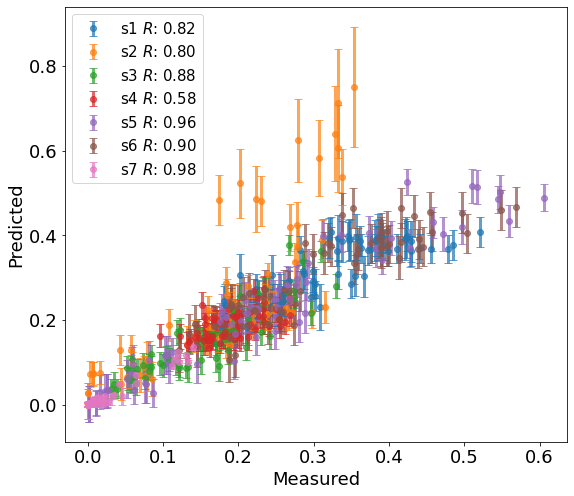

0.8829144686688367


In [11]:
plt.figure(figsize=(9,8))
r_vals = []
for i,s in enumerate(species):
    y_inds = np.in1d(kfold_species_names, s)
    y_s_true = np.array(kfold_y_true)[y_inds]
    y_s_pred = np.array(kfold_y_pred)[y_inds]
    y_s_stdv = np.array(kfold_y_stdv)[y_inds]
    
    # throw out zeros
    y_inds = y_s_true > 0.
    y_s_true = y_s_true[y_inds]
    y_s_pred = y_s_pred[y_inds]
    y_s_stdv = y_s_stdv[y_inds]
    
    r = linregress(y_s_true, y_s_pred).rvalue
    r_vals.append(r)
    plt.errorbar(y_s_true, y_s_pred, yerr = y_s_stdv, 
                 label=s+r" $R$: {:.2f}".format(r),
                 linewidth=3, capsize=4, c=f"C{i}", linestyle='none', marker='o', alpha=.7)

plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Measured", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.savefig("Results/glv_mf_kfold.pdf", dpi=150)
plt.show()
print(np.median(r_vals))